In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from utils.loaders import load_mnist
from models.AE import Autoencoder

### Defining the autoencoder

In [2]:
# run params
SECTION = 'vae'
RUN_ID = '0001'
DATA_NAME = 'digits'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

MODE =  'build' #'load' #

In [3]:
(x_train, y_train), (x_test, y_test) = load_mnist()

In [5]:
AE = Autoencoder(
    input_dim=(28, 28, 1),
    encoder_conv_filters=[32, 64, 64, 64],
    encoder_conv_kernel_size=[3, 3, 3, 3],
    encoder_conv_strides=[1, 2, 2, 1],
    decoder_conv_t_filters=[64, 64, 32, 1],
    decoder_conv_t_kernel_size=[3, 3, 3, 3],
    decoder_conv_t_strides=[1, 2, 2, 1],
    z_dim=2
)
if MODE == "build":
    AE.save(RUN_FOLDER)
else:
    AE.load_weights(os.path.join(RUN_FOLDER, "weights/weights.h5"))


Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [6]:
AE.encoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 64)          0   

In [7]:
AE.decoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 14, 14, 64)        0   

In [8]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
INITIAL_EPOCH = 0

In [9]:
AE.compile(LEARNING_RATE)

In [10]:
AE.train(     
    x_train[:1000],
    batch_size = BATCH_SIZE,
    epochs = 200,
    run_folder = RUN_FOLDER,
    initial_epoch = INITIAL_EPOCH
)

Train on 1000 samples
Epoch 1/200
 992/1000 [============================>.] - ETA: 0s - loss: 0.1669
Epoch 00001: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.1663
Epoch 2/200
 992/1000 [============================>.] - ETA: 0s - loss: 0.0772
Epoch 00002: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0771
Epoch 3/200
 992/1000 [============================>.] - ETA: 0s - loss: 0.0680
Epoch 00003: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0680
Epoch 4/200
 960/1000 [===========================>..] - ETA: 0s - loss: 0.0659
Epoch 00004: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0659
Epoch 5/200
 992/1000 [============================>.] - ETA: 0s - loss: 0.0610
Epoch 0000

Epoch 38/200
 992/1000 [============================>.] - ETA: 0s - loss: 0.0456
Epoch 00038: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0457
Epoch 39/200
 992/1000 [============================>.] - ETA: 0s - loss: 0.0458
Epoch 00039: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0458
Epoch 40/200
 960/1000 [===========================>..] - ETA: 0s - loss: 0.0456
Epoch 00040: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0455
Epoch 41/200
 992/1000 [============================>.] - ETA: 0s - loss: 0.0452
Epoch 00041: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0452
Epoch 42/200
 960/1000 [===========================>..] - ETA: 0s - loss: 0.0449
Epoch 00042: saving model t

Epoch 75/200
 960/1000 [===========================>..] - ETA: 0s - loss: 0.0405
Epoch 00075: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0405
Epoch 76/200
 992/1000 [============================>.] - ETA: 0s - loss: 0.0404
Epoch 00076: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0405
Epoch 77/200
 992/1000 [============================>.] - ETA: 0s - loss: 0.0404
Epoch 00077: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0404
Epoch 78/200
 992/1000 [============================>.] - ETA: 0s - loss: 0.0399
Epoch 00078: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0400
Epoch 79/200
 992/1000 [============================>.] - ETA: 0s - loss: 0.0403
Epoch 00079: saving model t

Epoch 112/200
 960/1000 [===========================>..] - ETA: 0s - loss: 0.0380
Epoch 00112: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0379
Epoch 113/200
 992/1000 [============================>.] - ETA: 0s - loss: 0.0377
Epoch 00113: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0378
Epoch 114/200
 992/1000 [============================>.] - ETA: 0s - loss: 0.0378
Epoch 00114: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0378
Epoch 115/200
 960/1000 [===========================>..] - ETA: 0s - loss: 0.0376
Epoch 00115: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0378
Epoch 116/200
 992/1000 [============================>.] - ETA: 0s - loss: 0.0382
Epoch 00116: saving mo

1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0363
Epoch 149/200
 992/1000 [============================>.] - ETA: 0s - loss: 0.0362
Epoch 00149: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0362
Epoch 150/200
 992/1000 [============================>.] - ETA: 0s - loss: 0.0363
Epoch 00150: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0364
Epoch 151/200
 992/1000 [============================>.] - ETA: 0s - loss: 0.0363
Epoch 00151: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0363
Epoch 152/200
 960/1000 [===========================>..] - ETA: 0s - loss: 0.0361
Epoch 00152: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0362
Epoch 153/200
 960/1000 [=====

 992/1000 [============================>.] - ETA: 0s - loss: 0.0352
Epoch 00185: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0352
Epoch 186/200
 992/1000 [============================>.] - ETA: 0s - loss: 0.0353
Epoch 00186: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0353
Epoch 187/200
 960/1000 [===========================>..] - ETA: 0s - loss: 0.0357
Epoch 00187: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0359
Epoch 188/200
 960/1000 [===========================>..] - ETA: 0s - loss: 0.0360
Epoch 00188: saving model to run/vae/0001_digits/weights/weights.h5
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0358
Epoch 189/200
 992/1000 [============================>.] - ETA: 0s - loss: 0.0352
Epoch 00189: saving model to run/vae

### Analysis of Autoencoder

In [3]:
from utils.loaders import load_mnist, load_model

# run params
SECTION = 'vae'
RUN_ID = '0001'
DATA_NAME = 'digits'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

In [15]:
(x_train, y_train), (x_test, y_test) = load_mnist()

In [16]:
AE = load_model(Autoencoder, RUN_FOLDER)

### Reconstructing Older Paintings


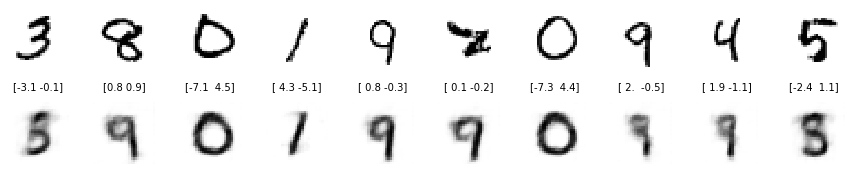

In [20]:

n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = AE.encoder.predict(example_images)

reconst_images = AE.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')

### Encoders Wall

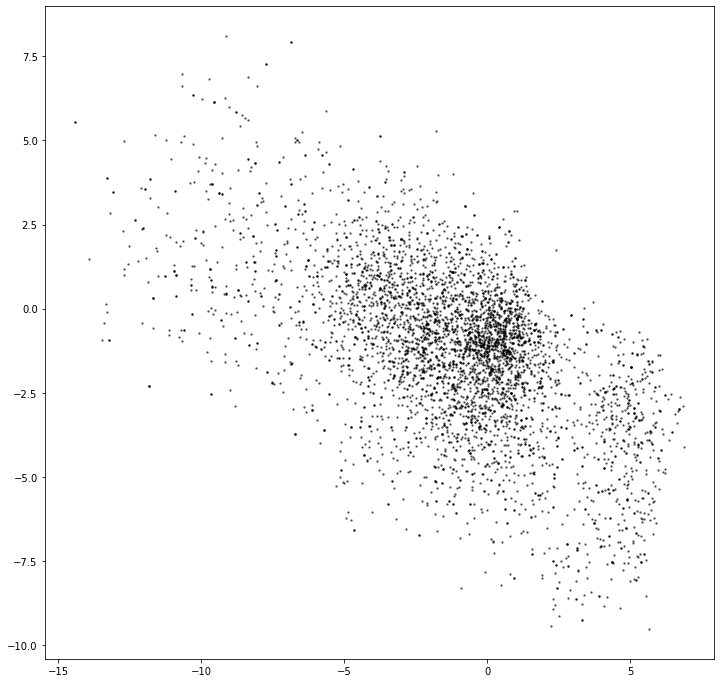

In [21]:
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()

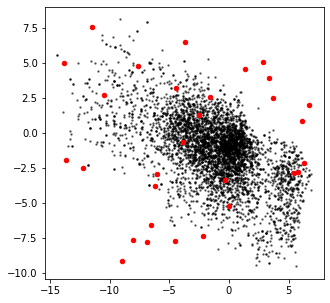

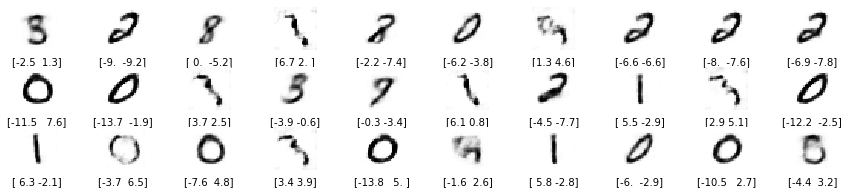

In [22]:
figsize = 5

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)

grid_size = 10
grid_depth = 3
figsize = 15

x = np.random.uniform(min_x,max_x, size = grid_size * grid_depth)
y = np.random.uniform(min_y,max_y, size = grid_size * grid_depth)
z_grid = np.array(list(zip(x, y)))
reconst = AE.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

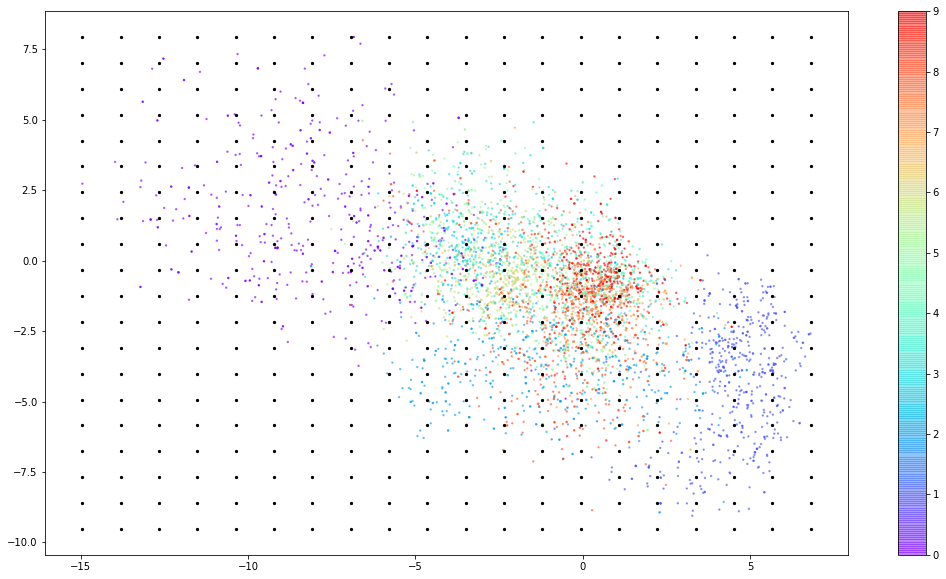

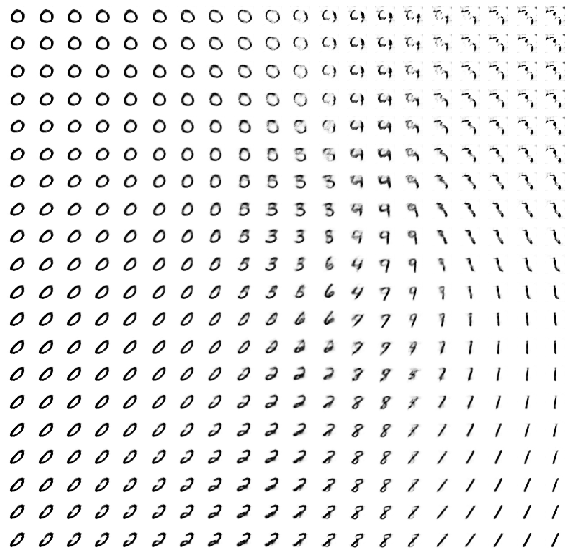

In [29]:
n_to_show = 5000
grid_size = 20
figsize = 10

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(18, 10))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

# x = norm.ppf(np.linspace(0.05, 0.95, 10))
# y = norm.ppf(np.linspace(0.05, 0.95, 10))
x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = AE.decoder.predict(z_grid)

plt.scatter(
    z_grid[:, 0], 
    z_grid[:, 1], 
    c = 'black', #cmap='rainbow' , c= example_labels
    alpha=1, 
    s=5
)
plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

### Variational Autoencoder

In [1]:
import os

from models.VAE import VariationalAutoencoder
from utils.loaders import load_mnist

In [2]:
# run params
SECTION = 'vae'
RUN_ID = '0002'
DATA_NAME = 'digits'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode = 'build' #'load' 

In [3]:
(x_train, y_train), (x_test, y_test) = load_mnist()

In [4]:
vae = VariationalAutoencoder(
    input_dim = (28,28,1),
    encoder_conv_filters = [32,64,64, 64],
    encoder_conv_kernel_size = [3,3,3,3],
    encoder_conv_strides = [1,2,2,1],
    decoder_conv_t_filters = [64,64,32,1],
    decoder_conv_t_kernel_size = [3,3,3,3],
    decoder_conv_t_strides = [1,2,2,1],
    z_dim = 2
)

vae.save(RUN_FOLDER)


Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [5]:
vae.encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 28, 28, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 14, 14, 64)   18496       leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [6]:
vae.decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0   

In [7]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000
BATCH_SIZE = 32
EPOCHS = 200
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

In [8]:
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

In [9]:
vae.train(     
    x_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    run_folder = RUN_FOLDER,
    print_every_n_batches = PRINT_EVERY_N_BATCHES,
    initial_epoch = INITIAL_EPOCH
)

Train on 60000 samples
Epoch 1/200
59968/60000 [============================>.] - ETA: 0s - loss: 58.7234 - vae_r_loss: 55.5235 - vae_kl_loss: 3.1999
Epoch 00001: saving model to run/vae/0002_digits/weights/weights-001-58.72.h5

Epoch 00001: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 87s 1ms/sample - loss: 58.7220 - vae_r_loss: 55.5221 - vae_kl_loss: 3.1999
Epoch 2/200
59936/60000 [============================>.] - ETA: 0s - loss: 51.8225 - vae_r_loss: 47.9502 - vae_kl_loss: 3.8724
Epoch 00002: saving model to run/vae/0002_digits/weights/weights-002-51.82.h5

Epoch 00002: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 84s 1ms/sample - loss: 51.8213 - vae_r_loss: 47.9488 - vae_kl_loss: 3.8725
Epoch 3/200
59968/60000 [============================>.] - ETA: 0s - loss: 50.3665 - vae_r_loss: 46.1752 - vae_kl_loss: 4.1913
Epoch 00003: saving model to run/vae/0002_digits/weights/w

Epoch 22/200
59936/60000 [============================>.] - ETA: 0s - loss: 45.6484 - vae_r_loss: 40.5139 - vae_kl_loss: 5.1344
Epoch 00022: saving model to run/vae/0002_digits/weights/weights-022-45.64.h5

Epoch 00022: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 80s 1ms/sample - loss: 45.6429 - vae_r_loss: 40.5082 - vae_kl_loss: 5.1347
Epoch 23/200
59936/60000 [============================>.] - ETA: 0s - loss: 45.5548 - vae_r_loss: 40.3955 - vae_kl_loss: 5.1594
Epoch 00023: saving model to run/vae/0002_digits/weights/weights-023-45.56.h5

Epoch 00023: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 80s 1ms/sample - loss: 45.5558 - vae_r_loss: 40.3964 - vae_kl_loss: 5.1594
Epoch 24/200
59936/60000 [============================>.] - ETA: 0s - loss: 45.4836 - vae_r_loss: 40.3185 - vae_kl_loss: 5.1650
Epoch 00024: saving model to run/vae/0002_digits/weights/weights-024-45.48.h5


W0218 09:06:45.173539 4575024576 callbacks.py:248] Method (on_train_batch_end) is slow compared to the batch update (0.119235). Check your callbacks.


59968/60000 [============================>.] - ETA: 0s - loss: 44.9125 - vae_r_loss: 39.6371 - vae_kl_loss: 5.2754
Epoch 00036: saving model to run/vae/0002_digits/weights/weights-036-44.91.h5

Epoch 00036: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 85s 1ms/sample - loss: 44.9114 - vae_r_loss: 39.6362 - vae_kl_loss: 5.2752
Epoch 37/200
59968/60000 [============================>.] - ETA: 0s - loss: 44.8693 - vae_r_loss: 39.5829 - vae_kl_loss: 5.2864
Epoch 00037: saving model to run/vae/0002_digits/weights/weights-037-44.87.h5

Epoch 00037: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 85s 1ms/sample - loss: 44.8663 - vae_r_loss: 39.5800 - vae_kl_loss: 5.2863
Epoch 38/200
59968/60000 [============================>.] - ETA: 0s - loss: 44.8337 - vae_r_loss: 39.5464 - vae_kl_loss: 5.2873
Epoch 00038: saving model to run/vae/0002_digits/weights/weights-038-44.84.h5

Epoch 00038:

Epoch 57/200
59936/60000 [============================>.] - ETA: 0s - loss: 44.3119 - vae_r_loss: 38.9337 - vae_kl_loss: 5.3782
Epoch 00057: saving model to run/vae/0002_digits/weights/weights-057-44.31.h5

Epoch 00057: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 84s 1ms/sample - loss: 44.3121 - vae_r_loss: 38.9337 - vae_kl_loss: 5.3783
Epoch 58/200
59968/60000 [============================>.] - ETA: 0s - loss: 44.3079 - vae_r_loss: 38.9260 - vae_kl_loss: 5.3819
Epoch 00058: saving model to run/vae/0002_digits/weights/weights-058-44.31.h5

Epoch 00058: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 85s 1ms/sample - loss: 44.3096 - vae_r_loss: 38.9276 - vae_kl_loss: 5.3819
Epoch 59/200
59936/60000 [============================>.] - ETA: 0s - loss: 44.2609 - vae_r_loss: 38.8758 - vae_kl_loss: 5.3852
Epoch 00059: saving model to run/vae/0002_digits/weights/weights-059-44.26.h5


Epoch 78/200
59968/60000 [============================>.] - ETA: 0s - loss: 43.9316 - vae_r_loss: 38.4841 - vae_kl_loss: 5.4475
Epoch 00078: saving model to run/vae/0002_digits/weights/weights-078-43.93.h5

Epoch 00078: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 87s 1ms/sample - loss: 43.9301 - vae_r_loss: 38.4828 - vae_kl_loss: 5.4473
Epoch 79/200
59936/60000 [============================>.] - ETA: 0s - loss: 43.9479 - vae_r_loss: 38.4945 - vae_kl_loss: 5.4534
Epoch 00079: saving model to run/vae/0002_digits/weights/weights-079-43.94.h5

Epoch 00079: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 88s 1ms/sample - loss: 43.9422 - vae_r_loss: 38.4889 - vae_kl_loss: 5.4533
Epoch 80/200
59968/60000 [============================>.] - ETA: 0s - loss: 43.9494 - vae_r_loss: 38.4960 - vae_kl_loss: 5.4534
Epoch 00080: saving model to run/vae/0002_digits/weights/weights-080-43.95.h5


Epoch 99/200
59936/60000 [============================>.] - ETA: 0s - loss: 43.6533 - vae_r_loss: 38.1601 - vae_kl_loss: 5.4932
Epoch 00099: saving model to run/vae/0002_digits/weights/weights-099-43.65.h5

Epoch 00099: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 83s 1ms/sample - loss: 43.6546 - vae_r_loss: 38.1615 - vae_kl_loss: 5.4932
Epoch 100/200
59968/60000 [============================>.] - ETA: 0s - loss: 43.7071 - vae_r_loss: 38.2233 - vae_kl_loss: 5.4837
Epoch 00100: saving model to run/vae/0002_digits/weights/weights-100-43.71.h5

Epoch 00100: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 85s 1ms/sample - loss: 43.7073 - vae_r_loss: 38.2238 - vae_kl_loss: 5.4836
Epoch 101/200
59968/60000 [============================>.] - ETA: 0s - loss: 43.6672 - vae_r_loss: 38.1716 - vae_kl_loss: 5.4956
Epoch 00101: saving model to run/vae/0002_digits/weights/weights-101-43.67.h

Epoch 120/200
59936/60000 [============================>.] - ETA: 0s - loss: 43.5130 - vae_r_loss: 37.9657 - vae_kl_loss: 5.5472
Epoch 00120: saving model to run/vae/0002_digits/weights/weights-120-43.52.h5

Epoch 00120: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 89s 1ms/sample - loss: 43.5203 - vae_r_loss: 37.9730 - vae_kl_loss: 5.5472
Epoch 121/200
59936/60000 [============================>.] - ETA: 0s - loss: 43.4992 - vae_r_loss: 37.9772 - vae_kl_loss: 5.5220
Epoch 00121: saving model to run/vae/0002_digits/weights/weights-121-43.50.h5

Epoch 00121: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 86s 1ms/sample - loss: 43.5027 - vae_r_loss: 37.9806 - vae_kl_loss: 5.5221
Epoch 122/200
59936/60000 [============================>.] - ETA: 0s - loss: 43.5120 - vae_r_loss: 37.9957 - vae_kl_loss: 5.5163
Epoch 00122: saving model to run/vae/0002_digits/weights/weights-122-43.51.

60000/60000 [==============================] - 89s 1ms/sample - loss: 43.3588 - vae_r_loss: 37.8130 - vae_kl_loss: 5.5458
Epoch 141/200
59968/60000 [============================>.] - ETA: 0s - loss: 43.3525 - vae_r_loss: 37.7979 - vae_kl_loss: 5.5547
Epoch 00141: saving model to run/vae/0002_digits/weights/weights-141-43.35.h5

Epoch 00141: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 89s 1ms/sample - loss: 43.3541 - vae_r_loss: 37.7996 - vae_kl_loss: 5.5546
Epoch 142/200
59936/60000 [============================>.] - ETA: 0s - loss: 43.3426 - vae_r_loss: 37.7837 - vae_kl_loss: 5.5589
Epoch 00142: saving model to run/vae/0002_digits/weights/weights-142-43.35.h5

Epoch 00142: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 86s 1ms/sample - loss: 43.3463 - vae_r_loss: 37.7873 - vae_kl_loss: 5.5590
Epoch 143/200
59936/60000 [============================>.] - ETA: 0s - loss: 43.33

59936/60000 [============================>.] - ETA: 0s - loss: 43.2560 - vae_r_loss: 37.6786 - vae_kl_loss: 5.5775
Epoch 00161: saving model to run/vae/0002_digits/weights/weights-161-43.26.h5

Epoch 00161: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 85s 1ms/sample - loss: 43.2573 - vae_r_loss: 37.6798 - vae_kl_loss: 5.5775
Epoch 162/200
59936/60000 [============================>.] - ETA: 0s - loss: 43.2390 - vae_r_loss: 37.6688 - vae_kl_loss: 5.5701
Epoch 00162: saving model to run/vae/0002_digits/weights/weights-162-43.24.h5

Epoch 00162: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 86s 1ms/sample - loss: 43.2367 - vae_r_loss: 37.6666 - vae_kl_loss: 5.5701
Epoch 163/200
59936/60000 [============================>.] - ETA: 0s - loss: 43.2003 - vae_r_loss: 37.6306 - vae_kl_loss: 5.5697
Epoch 00163: saving model to run/vae/0002_digits/weights/weights-163-43.20.h5

Epoch 0016

60000/60000 [==============================] - 84s 1ms/sample - loss: 43.1540 - vae_r_loss: 37.5654 - vae_kl_loss: 5.5886
Epoch 182/200
59936/60000 [============================>.] - ETA: 0s - loss: 43.1313 - vae_r_loss: 37.5347 - vae_kl_loss: 5.5966
Epoch 00182: saving model to run/vae/0002_digits/weights/weights-182-43.13.h5

Epoch 00182: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 86s 1ms/sample - loss: 43.1340 - vae_r_loss: 37.5374 - vae_kl_loss: 5.5966
Epoch 183/200
59936/60000 [============================>.] - ETA: 0s - loss: 43.1384 - vae_r_loss: 37.5467 - vae_kl_loss: 5.5917
Epoch 00183: saving model to run/vae/0002_digits/weights/weights-183-43.14.h5

Epoch 00183: saving model to run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 88s 1ms/sample - loss: 43.1406 - vae_r_loss: 37.5488 - vae_kl_loss: 5.5918
Epoch 184/200
59936/60000 [============================>.] - ETA: 0s - loss: 43.14

In [10]:
# run params
SECTION = 'vae'
RUN_ID = '0002'
DATA_NAME = 'digits'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

In [11]:
(x_train, y_train), (x_test, y_test) = load_mnist()

In [13]:
from utils.loaders import load_mnist, load_model

vae = load_model(VariationalAutoencoder, RUN_FOLDER)

### Reconstruction

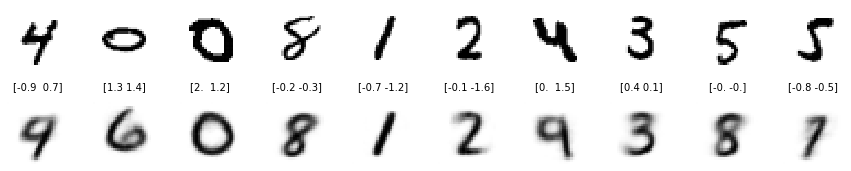

In [16]:
n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=sub.transAxes)
            
    sub.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img, cmap='gray_r')

### Encoders Output

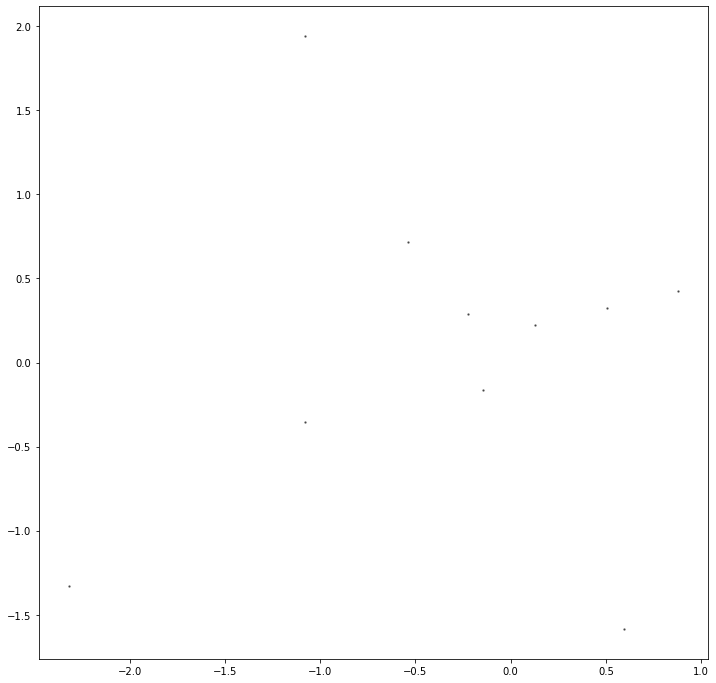

In [17]:
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae.encoder.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()


### Decoders Output

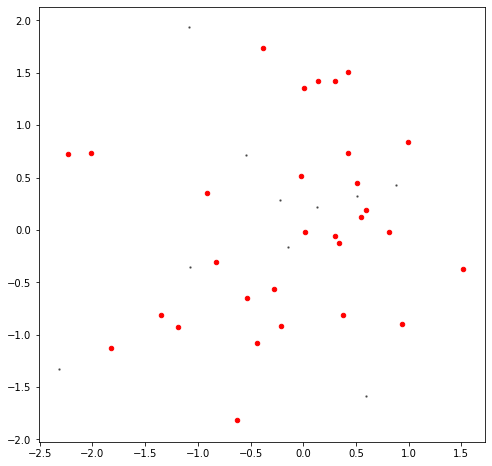

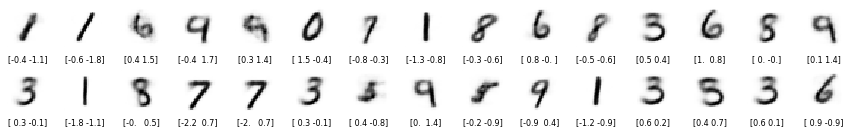

In [18]:
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)


grid_size = 15
grid_depth = 2
figsize = 15

x = np.random.normal(size = grid_size * grid_depth)
y = np.random.normal(size = grid_size * grid_depth)

z_grid = np.array(list(zip(x, y)))
reconst = vae.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=8, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')


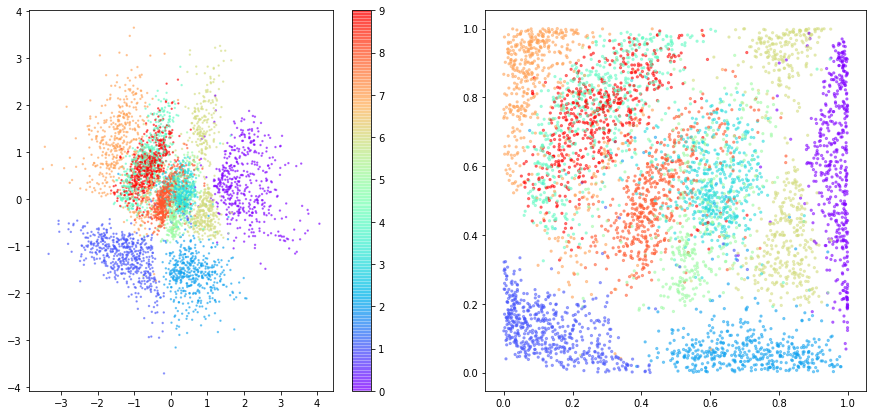

In [20]:
from scipy.stats import norm

n_to_show = 5000
grid_size = 15
fig_height = 7
fig_width = 15

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae.encoder.predict(example_images)
p_points = norm.cdf(z_points)

fig = plt.figure(figsize=(fig_width, fig_height))

ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar(plot_1)

ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(p_points[:, 0] , p_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=5)



plt.show()

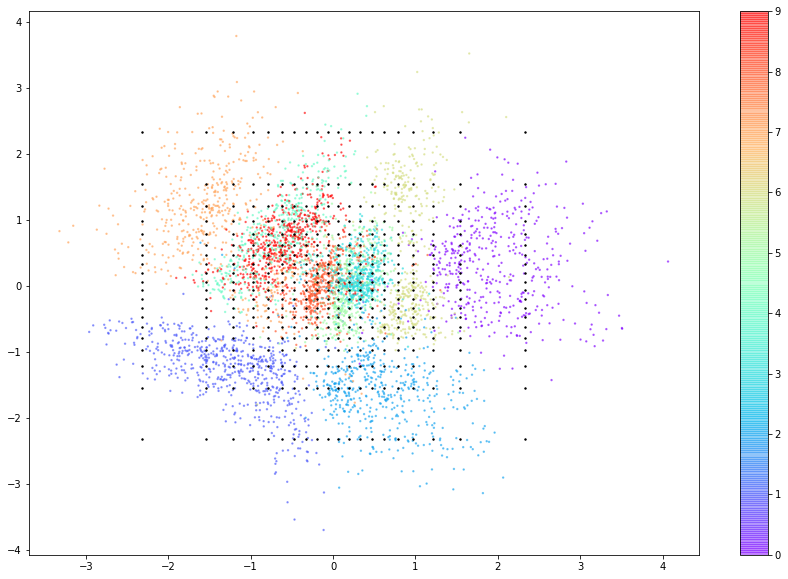

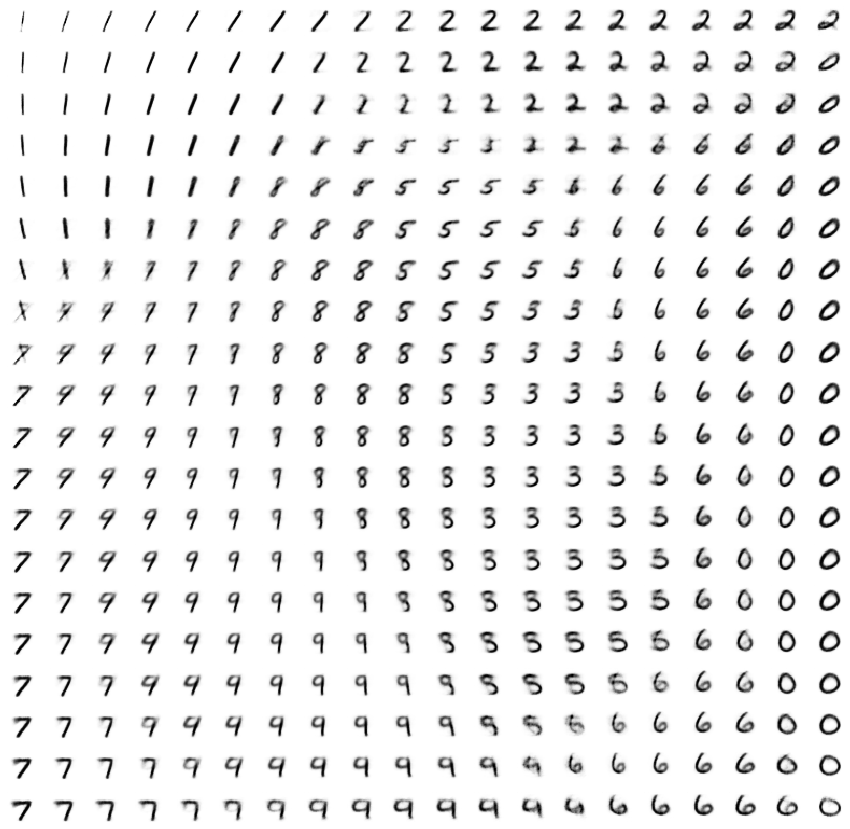

In [24]:
n_to_show = 5000
grid_size = 20
figsize = 15

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae.encoder.predict(example_images)

plt.figure(figsize=(15, 10))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

x = norm.ppf(np.linspace(0.01, 0.99, grid_size))
y = norm.ppf(np.linspace(0.01, 0.99, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = vae.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=2)




plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')